In [4]:
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
import scipy as sc
import numpy as np
import seaborn as sns

In [5]:
df = pd.DataFrame(pd.read_parquet("data/subj1.parquet"))

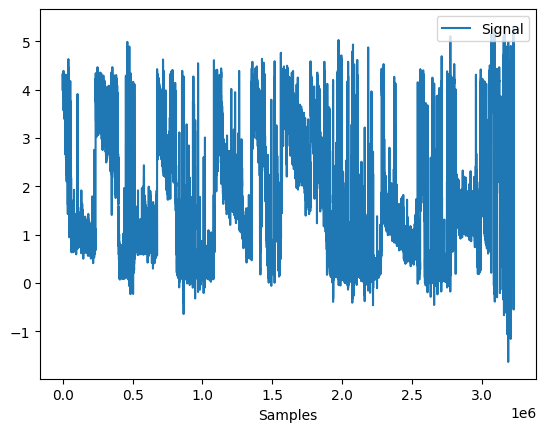

In [6]:
# Specifying EMG signal data, not super clean
emg_signal = df['EMG Submental_1']
nk.signal_plot(emg_signal)

In [7]:
# Making simple Bandpass filter to center data emulating neurokit function
def AHM_emg_clean(signal, sampling_rate=100, lowcut=1, highcut=49, order=1):
    nyquist = sampling_rate / 2
    sos = sc.signal.butter(order, [lowcut / nyquist, highcut / nyquist], btype='band', output='sos')
    filtered = sc.signal.sosfilt(sos, signal)
    return filtered

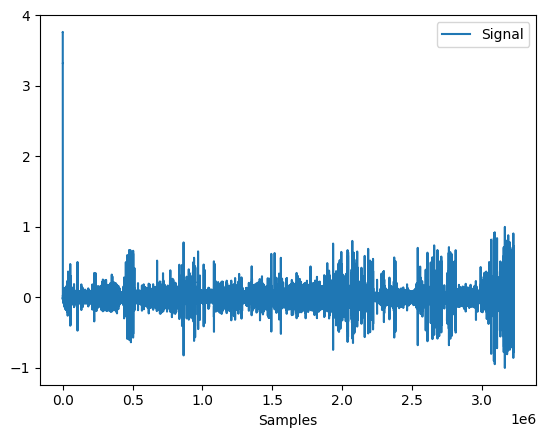

In [8]:
# Applying clean, huge spike at beginning is creating issues
emg_cleaned = AHM_emg_clean(emg_signal)
nk.signal_plot(emg_cleaned)

In [9]:
# Not the prettiest solution but setting first 200 values (2 seconds) to zero to eliminate large spike

emg_cleaned_0200 = emg_cleaned.copy()
emg_cleaned_0200[:200] = 0

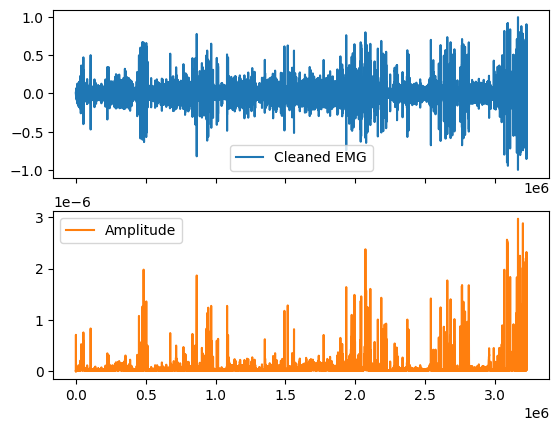

In [10]:
# Running neurokit2 amplitude function, it creates amplitude values from the signal

emg_amplitude = nk.emg_amplitude(emg_cleaned_0200)
fig = pd.DataFrame({"Cleaned EMG": emg_cleaned_0200, "Amplitude": emg_amplitude}).plot(subplots=True)

In [11]:
# Running neurokit2 activity funtion, it uses a gaussian mixture model to identify activation from amplitude data

emg_activity, info = nk.emg_activation(emg_amplitude=emg_amplitude)

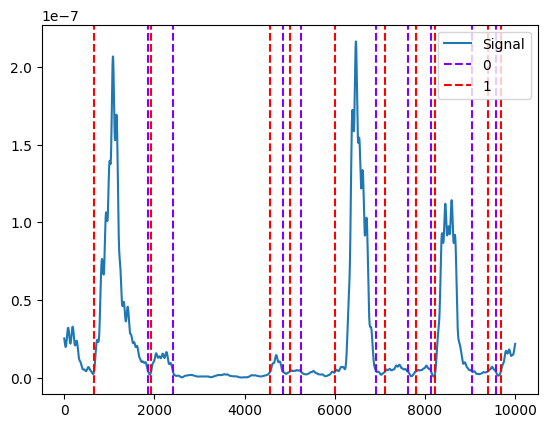

In [12]:
# Sample of what the identification looks like
activity_sample, info_sample = nk.emg_activation(emg_amplitude=emg_amplitude[2000000:2010000])
nk.events_plot([info_sample["EMG_Offsets"], info_sample["EMG_Onsets"]], emg_amplitude[2000000:2010000])

In [13]:
emg_activity['EMG_Amplitude'] = emg_amplitude
emg_activity

,EMG_Activity,EMG_Onsets,EMG_Offsets,EMG_Amplitude
0,0.0,0,0,7.758118e-10
1,0.0,0,0,7.971421e-10
2,0.0,0,0,8.181362e-10
3,0.0,0,0,8.387132e-10
4,0.0,0,0,8.587874e-10
...,...,...,...,...
3227994,0.0,0,0,7.769645e-08
3227995,0.0,0,0,7.761274e-08
3227996,0.0,0,0,7.752456e-08
3227997,0.0,0,0,7.743514e-08


In [14]:
# Creating epochs for activity data

event_onsets = np.arange(0, len(emg_signal), 3000)
emg_epochs = nk.epochs_create(emg_activity, events=event_onsets, sampling_rate=100)

In [15]:
# Running event related function to extract event features

emg_event_data = nk.emg_eventrelated(emg_epochs)
emg_event_data

c:\Users\Shadow\AppData\Local\Programs\Python\Python313\Lib\site-packages\neurokit2\epochs\eventrelated_utils.py:37: NeuroKitWarning: emg_eventrelated(): The duration of your epochs seems quite long. You might want to use emg_intervalrelated().
  warn(


,Label,Event_Onset,EMG_Activation,EMG_Amplitude_Mean,EMG_Amplitude_Max,EMG_Amplitude_SD,EMG_Amplitude_Max_Time,EMG_Bursts
1,1,0,1,3.291790e-07,6.998460e-07,2.314875e-07,2.000667,1.0
2,2,3000,1,1.759563e-08,2.230240e-08,2.760867e-09,19.586529,1.0
3,3,6000,0,NaN,NaN,NaN,NaN,NaN
4,4,9000,1,2.086021e-08,2.938142e-08,4.732392e-09,27.129043,2.0
5,5,12000,1,1.601815e-08,2.222536e-08,2.537544e-09,18.936312,3.0
...,...,...,...,...,...,...,...,...
1072,1072,3213000,1,7.118938e-08,4.340900e-07,9.596087e-08,0.010003,1.0
1073,1073,3216000,1,1.602763e-08,2.393154e-08,2.907339e-09,8.062688,2.0
1074,1074,3219000,1,1.955916e-08,3.530509e-08,6.597400e-09,1.530510,3.0
1075,1075,3222000,1,2.686031e-07,1.780451e-06,4.926559e-07,18.426142,4.0


<Axes: ylabel='EMG_Amplitude_Mean'>

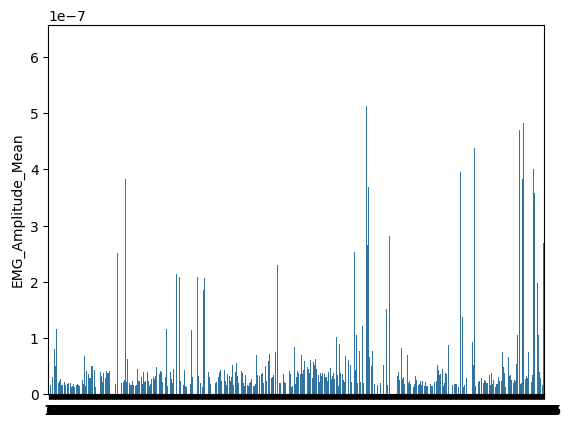

In [16]:
# Sample plot of amplitude mean

sns.barplot(emg_event_data['EMG_Amplitude_Mean'])